In [ ]:
import sys, os
nb_dir = os.path.dirname(os.getcwd()) if os.path.basename(os.getcwd()) == 'notebooks' else os.getcwd()
proj_root = nb_dir if os.path.isfile(os.path.join(nb_dir, 'config.py')) else os.path.dirname(nb_dir)
if proj_root not in sys.path:
    sys.path.insert(0, proj_root)
print('Using project root:', proj_root)

Using project root: c:\Users\arnav\Desktop\Arnav\ROG\Arnav\Arnav\python\ExoPatternNet


In [9]:
#import config and defaults
import config
from config import DEFAULTS
import os, numpy as np, pandas as pd, matplotlib.pyplot as plt
import lightkurve as lk

MISSION = DEFAULTS["mission"]
FL_WIN = DEFAULTS["flatten_window_length"]
FL_POLY = DEFAULTS["flatten_polyorder"]
QUALITY = DEFAULTS["quality_mask"]
OFFLINE = DEFAULTS["offline_mode"]

DATA_RAW = "data/raw"
DATA_PRO = "data/processed"
os.makedirs(DATA_RAW, exist_ok=True)
os.makedirs(DATA_PRO, exist_ok=True)


In [10]:
#loading files from local or online
def load_from_file(path: str) -> lk.LightCurve:
    obj = lk.read(path)  
    if hasattr(obj, "PDCSAP_FLUX") and obj.PDCSAP_FLUX is not None:
        lc = obj.PDCSAP_FLUX
    elif hasattr(obj, "SAP_FLUX") and obj.SAP_FLUX is not None:
        lc = obj.SAP_FLUX
    else:
        lc = obj if hasattr(obj, "time") else obj.stitch()
    return lc.remove_nans()

def load_by_id(target_id: str, mission="Kepler") -> lk.LightCurve:
    sr = lk.search_lightcurve(target_id, mission=mission)
    if len(sr) == 0:
        raise ValueError(f"No light curve for {target_id} / {mission}")
    obj = sr.download()   
    if obj is None:
        raise RuntimeError("download() returned None")
    if hasattr(obj, "PDCSAP_FLUX") and obj.PDCSAP_FLUX is not None:
        lc = obj.PDCSAP_FLUX
    elif hasattr(obj, "SAP_FLUX") and obj.SAP_FLUX is not None:
        lc = obj.SAP_FLUX
    else:
        lc = obj if hasattr(obj, "time") else obj.stitch()
    try:
        lc = lc.stitch()
    except Exception:
        pass
    return lc.remove_nans()


In [11]:
# Option A: local file (recommended for true offline)
#still need to be implemented

# Option B: online (will use cache if available)
target_id = "Kepler-10"
lc_raw = load_by_id(target_id, mission=MISSION)
lc_raw


c:\Users\arnav\miniconda3\envs\exopattern\lib\site-packages\lightkurve\search.py:424: LightkurveWarning: Warning: 50 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(
C:\Users\arnav\AppData\Local\Temp\ipykernel_31060\2504173214.py:19: LightkurveDeprecationWarning: The PDCSAP_FLUX function is deprecated and may be removed in a future version.
  if hasattr(obj, "PDCSAP_FLUX") and obj.PDCSAP_FLUX is not None:
C:\Users\arnav\AppData\Local\Temp\ipykernel_31060\2504173214.py:20: LightkurveDeprecationWarning: The PDCSAP_FLUX function is deprecated and may be removed in a future version.
  lc = obj.PDCSAP_FLUX


time,flux,flux_err,quality,timecorr,centroid_col,centroid_row,cadenceno,sap_flux,sap_flux_err,sap_bkg,sap_bkg_err,pdcsap_flux,pdcsap_flux_err,sap_quality,psf_centr1,psf_centr1_err,psf_centr2,psf_centr2_err,mom_centr1,mom_centr1_err,mom_centr2,mom_centr2_err,pos_corr1,pos_corr2
,electron / s,electron / s,,d,pix,pix,,electron / s,electron / s,electron / s,electron / s,electron / s,electron / s,,pix,pix,pix,pix,pix,pix,pix,pix,pix,pix
Time,float32,float32,int32,float32,float64,float64,int32,float32,float32,float32,float32,float32,float32,int32,float64,float32,float64,float32,float64,float32,float64,float32,float32,float32
200.32408500967722,5.5696000e+05,1.1305735e+02,0,2.622170e-03,655.63318,250.32889,122650,5.5629538e+05,1.1105357e+02,3.4163665e+03,6.7321736e-01,5.5696000e+05,1.1305735e+02,0,———,———,———,———,655.63318,2.0087537e-04,250.32889,2.8624298e-04,-8.9440849e-03,3.7062202e-02
200.3247661127025,5.5708588e+05,1.1307109e+02,0,2.622173e-03,655.63361,250.32593,122651,5.5642056e+05,1.1106165e+02,3.4168267e+03,6.7319971e-01,5.5708588e+05,1.1307109e+02,0,———,———,———,———,655.63361,2.0079174e-04,250.32593,2.8616333e-04,-8.9426376e-03,3.7056953e-02
200.32544721572776,5.5703188e+05,1.1307073e+02,0,2.622176e-03,655.63319,250.32772,122652,5.5636775e+05,1.1105553e+02,3.4172874e+03,6.7318219e-01,5.5703188e+05,1.1307073e+02,0,———,———,———,———,655.63319,2.0085592e-04,250.32772,2.8623262e-04,-8.9411894e-03,3.7051704e-02
200.32612831898587,5.5684444e+05,1.1306761e+02,0,2.622179e-03,655.63277,250.32793,122653,5.5618300e+05,1.1104655e+02,3.4177478e+03,6.7316467e-01,5.5684444e+05,1.1306761e+02,0,———,———,———,———,655.63277,2.0090178e-04,250.32793,2.8624505e-04,-8.9397421e-03,3.7046455e-02
200.3268094220184,5.5680788e+05,1.1306657e+02,0,2.622182e-03,655.63314,250.32734,122654,5.5614750e+05,1.1103952e+02,3.4182083e+03,6.7314714e-01,5.5680788e+05,1.1306657e+02,0,———,———,———,———,655.63314,2.0090664e-04,250.32734,2.8633900e-04,-8.9382939e-03,3.7041202e-02
200.3274905250437,5.5690000e+05,1.1308340e+02,0,2.622185e-03,655.63494,250.32809,122655,5.5623925e+05,1.1105020e+02,3.4186687e+03,6.7312962e-01,5.5690000e+05,1.1308340e+02,0,———,———,———,———,655.63494,2.0091342e-04,250.32809,2.8628414e-04,-8.9368466e-03,3.7035953e-02
200.32817172830255,5.5693525e+05,1.1309309e+02,10000000000000,2.622188e-03,655.63234,250.32742,122656,5.5627475e+05,1.1105363e+02,3.4191294e+03,6.7311198e-01,5.5693525e+05,1.1309309e+02,10000000000000,———,———,———,———,655.63234,2.0093309e-04,250.32742,2.8624979e-04,-8.9353984e-03,3.7030704e-02
200.32885283132782,5.5703019e+05,1.1310329e+02,0,2.622191e-03,655.63383,250.32734,122657,5.5636931e+05,1.1105746e+02,3.4195896e+03,6.7309445e-01,5.5703019e+05,1.1310329e+02,0,———,———,———,———,655.63383,2.0092484e-04,250.32734,2.8618125e-04,-8.9339502e-03,3.7025455e-02


In [12]:
#Cleaning of data for better results (removing strong outliers and long term trends)
def apply_quality_and_clean(lc: lk.LightCurve, quality_mask="hard") -> lk.LightCurve:
    # Lightkurve quality flags are already applied in PDCSAP typically, but be conservative
    try:
        lc = lc.remove_outliers(sigma_lower=10, sigma_upper=5)
    except Exception:
        pass
    return lc.remove_nans()

def flatten_and_normalize(lc: lk.LightCurve, window_length=401, polyorder=2) -> lk.LightCurve:
    if window_length <= polyorder:
        window_length = polyorder * 2 + 1
    flat = lc.flatten(window_length=window_length, polyorder=polyorder)
    # normalize to median ~ 1.0
    flux = flat.flux.value if hasattr(flat.flux, "value") else flat.flux
    med = np.nanmedian(flux)
    if not np.isfinite(med) or med == 0:
        med = 1.0
    norm = flux / med
    return lk.LightCurve(time=flat.time, flux=norm, flux_err=getattr(flat, "flux_err", None), quality=getattr(flat, "quality", None))

lc_clean = apply_quality_and_clean(lc_raw, QUALITY)
lc_flat  = flatten_and_normalize(lc_clean, FL_WIN, FL_POLY)


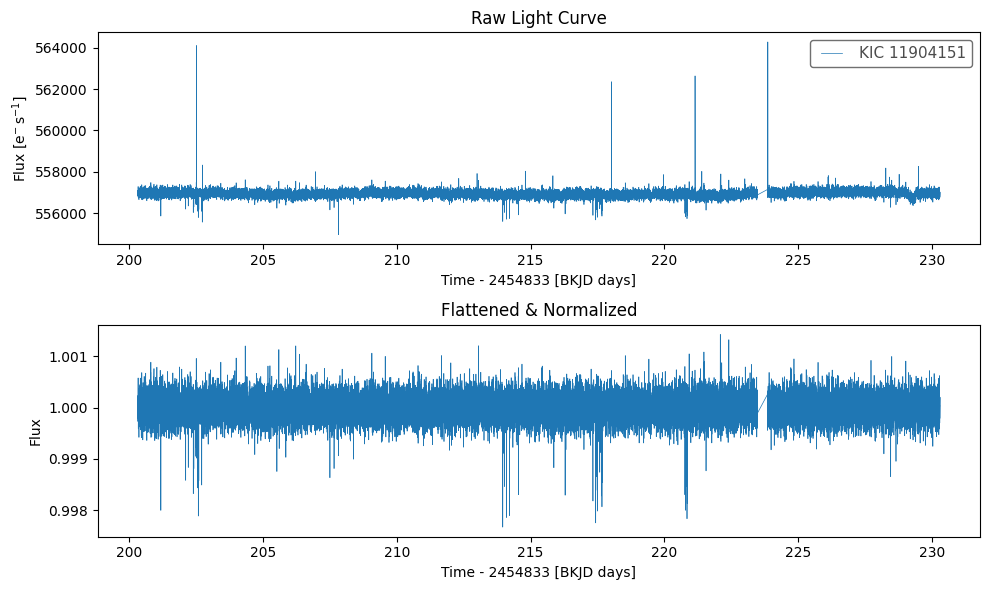

In [13]:
fig, ax = plt.subplots(2,1, figsize=(10,6), sharex=False)
lc_raw.plot(ax=ax[0])
ax[0].set_title("Raw Light Curve")
lc_flat.plot(ax=ax[1])
ax[1].set_title("Flattened & Normalized")
plt.tight_layout()
plt.show()


In [14]:
df = lc_flat.to_pandas()
out_csv = os.path.join(DATA_PRO, f"{target_id.replace(' ','_')}_{MISSION}_flattened.csv")
df.to_csv(out_csv, index=False)
out_csv


'data/processed\\Kepler-10_Kepler_flattened.csv'